In [1]:
import pyspark
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.mllib.stat import Statistics

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request

%matplotlib inline

In [2]:
sc = SparkContext()
sqlsc = SQLContext(sc)
spark = sqlsc.sparkSession

# 1. Importing database

In [3]:
filename = [
    'application_train',
    'bureau',
    'bureau_balance',
    'credit_card_balance',
    'installments_payments',
    'POS_CASH_balance',
    'previous_application'
]

data = {}

# Store all datafiles in a dictionary
for file in tqdm(filename):
    if file in data.keys():
        print(file + ' already exists in dictionary')
    else:
        filepath = '../home-credit-default-risk/' + file + '.csv'
        dff = spark.read.csv(filepath, header = True, sep = ',', inferSchema = True)
        data[file] = dff

100%|██████████| 7/7 [02:10<00:00, 18.71s/it]


## 1.1. Summarizing dataframes

In [4]:
res = []
for key in data.keys():
    res.append([key, len(data[key].columns), data[key].count()])
tab1 = pd.DataFrame(res, columns = ['DF', 'Nbr columns', 'Nbr observations'])
tab1

,DF,Nbr columns,Nbr observations
0,application_train,122,307511
1,bureau,17,1716428
2,bureau_balance,3,27299925
3,credit_card_balance,23,3840312
4,installments_payments,8,13605401
5,POS_CASH_balance,8,10001358
6,previous_application,37,1670214


## 1.2. Missing values counting

In [5]:
def missing_data(x):
    df = data[x]
    dff = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
    dff = dff.withColumn('Column', lit('Total')).toPandas().set_index('Column').transpose()
    dff['Percent'] = (dff['Total']*100/df.count()).round(2)
    return dff

In [6]:
print('Top 20 missing values variables in ...')
for i in filename:
    dff = missing_data(i)
    print('{} with total {} observations'.format(i, data[i].count()))
    print(dff.sort_values('Total', ascending = False).head(15))
    print('\n')

Top 20 missing values variables in ...
application_train with total 307511 observations
Column                     Total  Percent
COMMONAREA_MEDI           214865    69.87
COMMONAREA_AVG            214865    69.87
COMMONAREA_MODE           214865    69.87
NONLIVINGAPARTMENTS_MODE  213514    69.43
NONLIVINGAPARTMENTS_AVG   213514    69.43
NONLIVINGAPARTMENTS_MEDI  213514    69.43
FONDKAPREMONT_MODE        210295    68.39
LIVINGAPARTMENTS_MODE     210199    68.35
LIVINGAPARTMENTS_AVG      210199    68.35
LIVINGAPARTMENTS_MEDI     210199    68.35
FLOORSMIN_AVG             208642    67.85
FLOORSMIN_MODE            208642    67.85
FLOORSMIN_MEDI            208642    67.85
YEARS_BUILD_MEDI          204488    66.50
YEARS_BUILD_MODE          204488    66.50


bureau with total 1716428 observations
Column                    Total  Percent
AMT_ANNUITY             1226791    71.47
AMT_CREDIT_MAX_OVERDUE  1124488    65.51
DAYS_ENDDATE_FACT        633653    36.92
AMT_CREDIT_SUM_LIMIT     591780    

# 2. EDA sub-dataframes

- **SK_ID_CURR** connects the dataframes *application_train|test*, *bureau*, *previous_application*, *POS_CASH_balance*, *installments_payment* and *credit_card_balance*

- **SK_ID_PREV** connects the dataframes *previous_application*, *POS_CASH_balance*, *installments_payment* and *credit_card_balance*

- **SK_ID_PREV** connects the dataframes *bureau* and *bureau_balance*

<img src="https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png">

In [7]:
table2 = []
for df in filename:
    if 'SK_ID_CURR' in data[df].columns:
        temps1 = data[df].select(F.countDistinct("SK_ID_CURR")).collect()[0][0]
    else:
        temps1 = 0
        
    if 'SK_ID_PREV' in data[df].columns:
        temps2 = data[df].select(F.countDistinct("SK_ID_PREV")).collect()[0][0]
    else:
        temps2 = 0
        
    table2.append([df, data[df].count(), temps1, temps2])

# Distinct number or current/previous applications in each dataframe 
tab2 = pd.DataFrame(table2, columns = ['DF', 'Nbr_TOTAL', 'Nbr_CURR', 'Nbr_PREV'])
tab2

,DF,Nbr_TOTAL,Nbr_CURR,Nbr_PREV
0,application_train,307511,307511,0
1,bureau,1716428,305811,0
2,bureau_balance,27299925,0,0
3,credit_card_balance,3840312,103558,104307
4,installments_payments,13605401,339587,997752
5,POS_CASH_balance,10001358,337252,936325
6,previous_application,1670214,338857,1670214


## 2.1. Dataframe `installments_payments`

**This dataframe provides the repayment history for the previously disbursed credits in Home Credit related to the loans in our sample. This part I study the distribution of several variables which divided into 2 group of default (TARGET = 1) and non-default (TARGET = 0)**

In [8]:
key = 'installments_payments'
print('Dataframe {} includes {} features (columns) and {} observations.'.format(
    key,
    len(data[key].columns),
    data[key].count()
))
data[key].printSchema()

Dataframe installments_payments includes 8 features (columns) and 13605401 observations.
root
 |-- SK_ID_PREV: integer (nullable = true)
 |-- SK_ID_CURR: integer (nullable = true)
 |-- NUM_INSTALMENT_VERSION: double (nullable = true)
 |-- NUM_INSTALMENT_NUMBER: integer (nullable = true)
 |-- DAYS_INSTALMENT: double (nullable = true)
 |-- DAYS_ENTRY_PAYMENT: double (nullable = true)
 |-- AMT_INSTALMENT: double (nullable = true)
 |-- AMT_PAYMENT: double (nullable = true)



In [9]:
df1 = data[key]

# Difference between the actual paid amount and prescribed installment
df1 = df1.withColumn('AMT_LEFT', col('AMT_INSTALMENT') - col('AMT_PAYMENT'))

# Number of late payments
df1 = df1.withColumn('DAYS_LATE', col('DAYS_INSTALMENT') - col('DAYS_ENTRY_PAYMENT'))

# Aggregation total number of previous applications by current applications
df1 = df1.groupBy(['SK_ID_CURR']).agg(
    F.count(col('SK_ID_PREV')).alias('NBR_SK_ID_PREV'),
    avg(col('AMT_LEFT')).alias('AVG_AMT_LEFT'),
    avg(col('DAYS_LATE')).alias('AVG_DAYS_LATE'),
    (F.sum(col('AMT_LEFT'))/F.sum(col('AMT_INSTALMENT'))).alias('PERC_AMT_LEFT')
)

In [10]:
temps = df1.select([F.col(c).alias("IP_"+c) for c in df1.columns])
df_merge = data['application_train'].join(
    temps,
    data['application_train'].SK_ID_CURR == temps.IP_SK_ID_CURR,
    how = 'inner'
)

In [11]:
def plot_dist_TARGET(dta, var, nrow):
    i = 0
    temps = dta.select(['TARGET'] + var).na.fill(0)
    t1 = temps.filter(col('TARGET') == 1).toPandas()
    t0 = temps.filter(col('TARGET') == 0).toPandas()

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,12))

    for feature in var:
        i += 1
        corr = temps.stat.corr('TARGET', feature)
        med1 = temps.filter(col('TARGET') == 1).approxQuantile(feature, [0.5], 0)
        med2 = temps.filter(col('TARGET') == 0).approxQuantile(feature, [0.5], 0)
        print('Correlation %s and TARGET is %0.4f' % (feature, corr))
        print('Median value for default loan = %0.4f' % med1[0])
        print('Median value for non-default loan = %0.4f' % med2[0])
        print('\n')
        
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)

Correlation IP_NBR_SK_ID_PREV and TARGET is -0.0211
Median value for default loan = 23.0000
Median value for non-default loan = 25.0000


Correlation IP_AVG_AMT_LEFT and TARGET is 0.0293
Median value for default loan = 0.0000
Median value for non-default loan = 0.0000


Correlation IP_AVG_DAYS_LATE and TARGET is -0.0209
Median value for default loan = 8.6316
Median value for non-default loan = 9.6250


Correlation IP_PERC_AMT_LEFT and TARGET is 0.0527
Median value for default loan = 0.0000
Median value for non-default loan = 0.0000




<Figure size 432x288 with 0 Axes>

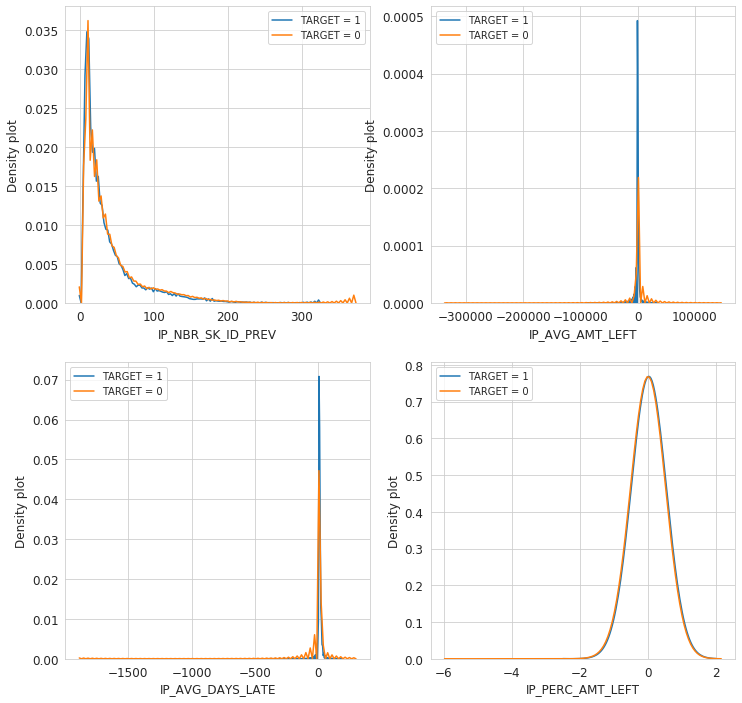

In [12]:
var = [
    'IP_NBR_SK_ID_PREV',
    'IP_AVG_AMT_LEFT',
    'IP_AVG_DAYS_LATE',
    'IP_PERC_AMT_LEFT'
]
plot_dist_TARGET(df_merge, var, nrow = 2)

## 2.2. Dataframe  `POS_CASH_balance`

<b>Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit

In [13]:
key = 'POS_CASH_balance'
print('Dataframe {} includes {} features (columns) and {} observations.'.format(
    key,
    len(data[key].columns),
    data[key].count()
))
data[key].printSchema()

Dataframe POS_CASH_balance includes 8 features (columns) and 10001358 observations.
root
 |-- SK_ID_PREV: integer (nullable = true)
 |-- SK_ID_CURR: integer (nullable = true)
 |-- MONTHS_BALANCE: integer (nullable = true)
 |-- CNT_INSTALMENT: double (nullable = true)
 |-- CNT_INSTALMENT_FUTURE: double (nullable = true)
 |-- NAME_CONTRACT_STATUS: string (nullable = true)
 |-- SK_DPD: integer (nullable = true)
 |-- SK_DPD_DEF: integer (nullable = true)



In [14]:
df2 = data[key]
df2.groupBy("NAME_CONTRACT_STATUS").count()\
    .withColumn('percent', F.round(col('count')*100/df2.count(),2))\
    .show()

+--------------------+-------+-------+
|NAME_CONTRACT_STATUS|  count|percent|
+--------------------+-------+-------+
|              Demand|   7065|   0.07|
|            Approved|   4917|   0.05|
|           Completed| 744883|   7.45|
|      Amortized debt|    636|   0.01|
|Returned to the s...|   5461|   0.05|
|                 XNA|      2|    0.0|
|              Active|9151119|   91.5|
|              Signed|  87260|   0.87|
|            Canceled|     15|    0.0|
+--------------------+-------+-------+



In [15]:
dff2 = df2.groupBy(['SK_ID_CURR']).agg(
    F.count(col('SK_ID_PREV')).alias('NBR_SK_ID_PREV'),
    avg(col('CNT_INSTALMENT_FUTURE')).alias('AVG_CNT_INSTALMENT_FUTURE'), 
    avg(col('SK_DPD_DEF')).alias('AVG_SK_DPD_DEF'),
    (F.sum(col('CNT_INSTALMENT_FUTURE'))/F.sum(col('CNT_INSTALMENT'))).alias('PERC_CNT_LEFT')
)

temps = dff2.select([F.col(c).alias("POS_"+c) for c in dff2.columns])

df_merge = data['application_train'].join(
    temps,
    data['application_train'].SK_ID_CURR == temps.POS_SK_ID_CURR,
    how = 'inner'
)
df_merge.count()

289444

Correlation POS_NBR_SK_ID_PREV and TARGET is -0.0356
Median value for default loan = 19.0000
Median value for non-default loan = 23.0000


Correlation POS_AVG_CNT_INSTALMENT_FUTURE and TARGET is 0.0278
Median value for default loan = 7.2000
Median value for non-default loan = 6.9211


Correlation POS_AVG_SK_DPD_DEF and TARGET is 0.0065
Median value for default loan = 0.0000
Median value for non-default loan = 0.0000


Correlation POS_PERC_CNT_LEFT and TARGET is 0.0308
Median value for default loan = 0.5833
Median value for non-default loan = 0.5690




<Figure size 432x288 with 0 Axes>

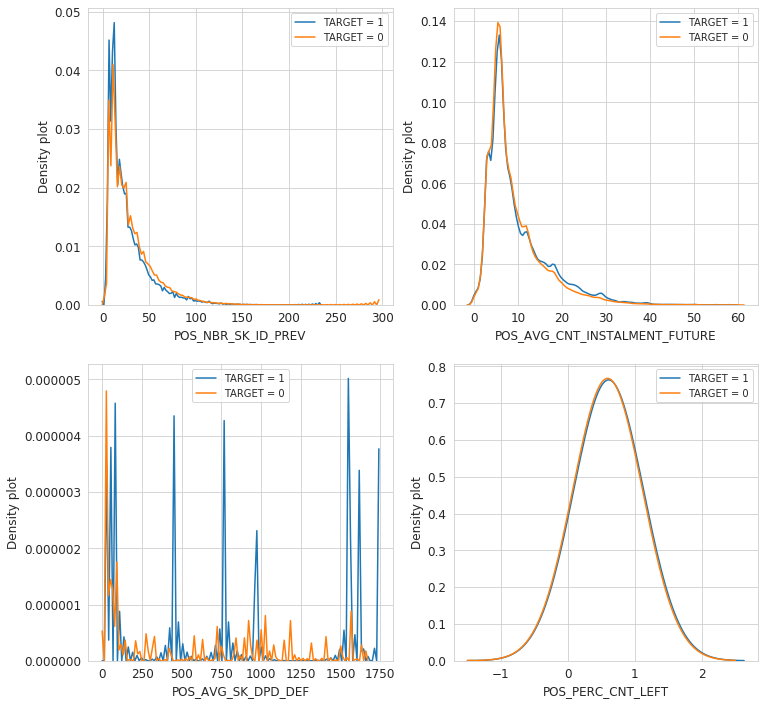

In [16]:
var = [
    'POS_NBR_SK_ID_PREV',
    'POS_AVG_CNT_INSTALMENT_FUTURE',
    'POS_AVG_SK_DPD_DEF',
    'POS_PERC_CNT_LEFT'
]
plot_dist_TARGET(df_merge, var, nrow = 2)

## 2.3. Dataframe `credit_card_balance`

In [17]:
key = 'credit_card_balance'
print('Dataframe {} includes {} features (columns) and {} observations.'.format(
    key,
    len(data[key].columns),
    data[key].count()
))
data[key].printSchema()

Dataframe credit_card_balance includes 23 features (columns) and 3840312 observations.
root
 |-- SK_ID_PREV: integer (nullable = true)
 |-- SK_ID_CURR: integer (nullable = true)
 |-- MONTHS_BALANCE: integer (nullable = true)
 |-- AMT_BALANCE: double (nullable = true)
 |-- AMT_CREDIT_LIMIT_ACTUAL: integer (nullable = true)
 |-- AMT_DRAWINGS_ATM_CURRENT: double (nullable = true)
 |-- AMT_DRAWINGS_CURRENT: double (nullable = true)
 |-- AMT_DRAWINGS_OTHER_CURRENT: double (nullable = true)
 |-- AMT_DRAWINGS_POS_CURRENT: double (nullable = true)
 |-- AMT_INST_MIN_REGULARITY: double (nullable = true)
 |-- AMT_PAYMENT_CURRENT: double (nullable = true)
 |-- AMT_PAYMENT_TOTAL_CURRENT: double (nullable = true)
 |-- AMT_RECEIVABLE_PRINCIPAL: double (nullable = true)
 |-- AMT_RECIVABLE: double (nullable = true)
 |-- AMT_TOTAL_RECEIVABLE: double (nullable = true)
 |-- CNT_DRAWINGS_ATM_CURRENT: double (nullable = true)
 |-- CNT_DRAWINGS_CURRENT: integer (nullable = true)
 |-- CNT_DRAWINGS_OTHER_CURRE

In [18]:
df3 = data[key]
df3.groupBy("NAME_CONTRACT_STATUS").count()\
    .withColumn('percent', F.round(col('count')*100/df3.count(),2))\
    .show()

+--------------------+-------+-------+
|NAME_CONTRACT_STATUS|  count|percent|
+--------------------+-------+-------+
|              Demand|   1365|   0.04|
|            Approved|      5|    0.0|
|           Completed| 128918|   3.36|
|              Active|3698436|  96.31|
|              Signed|  11058|   0.29|
|       Sent proposal|    513|   0.01|
|             Refused|     17|    0.0|
+--------------------+-------+-------+



In [19]:
dff3 = df3.groupBy(['SK_ID_CURR']).agg(
    F.count(col('SK_ID_PREV')).alias('NBR_SK_ID_PREV'),
    avg(col('AMT_PAYMENT_TOTAL_CURRENT')).alias('AVG_AMT_PAYMENT_TOTAL'), 
    avg(col('AMT_TOTAL_RECEIVABLE')).alias('AVG_SK_DPD_DEF'),
    F.sum(col('CNT_INSTALMENT_MATURE_CUM')).alias('SUM_CNT_INSTALMENT_MATURE')
)

temps = dff3.select([F.col(c).alias("CR_"+c) for c in dff3.columns])

df_merge = data['application_train'].join(
    temps,
    data['application_train'].SK_ID_CURR == temps.CR_SK_ID_CURR,
    how = 'inner'
)
df_merge.count()

86905

Correlation CR_NBR_SK_ID_PREV and TARGET is -0.0605
Median value for default loan = 16.0000
Median value for non-default loan = 22.0000


Correlation CR_AVG_AMT_PAYMENT_TOTAL and TARGET is 0.0227
Median value for default loan = 5985.5625
Median value for non-default loan = 3906.8182


Correlation CR_AVG_SK_DPD_DEF and TARGET is 0.0865
Median value for default loan = 61815.1001
Median value for non-default loan = 23721.9764


Correlation CR_SUM_CNT_INSTALMENT_MATURE and TARGET is -0.0424
Median value for default loan = 45.0000
Median value for non-default loan = 52.0000




<Figure size 432x288 with 0 Axes>

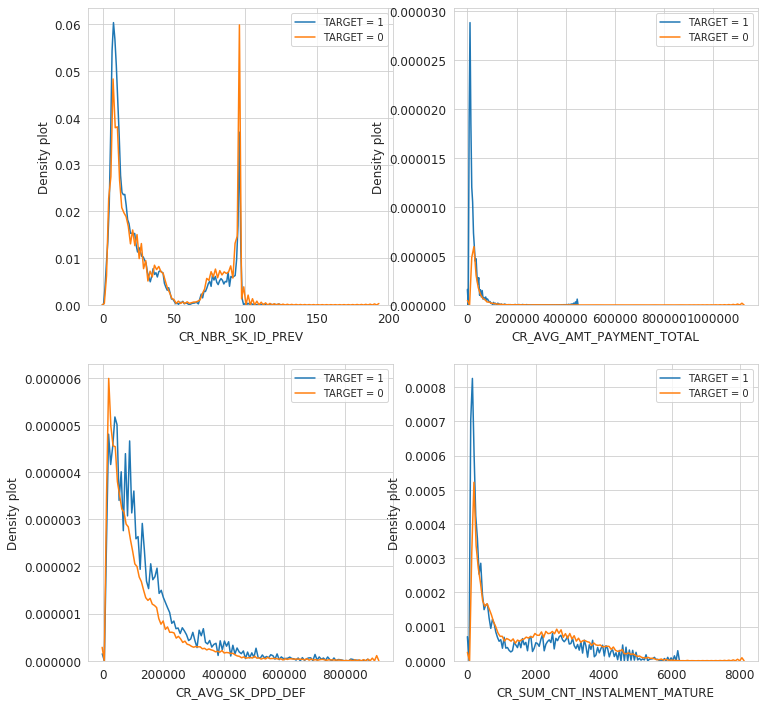

In [20]:
var = [
    'CR_NBR_SK_ID_PREV',
    'CR_AVG_AMT_PAYMENT_TOTAL',
    'CR_AVG_SK_DPD_DEF',
    'CR_SUM_CNT_INSTALMENT_MATURE',
]
plot_dist_TARGET(df_merge, var, nrow = 2)

## 2.4. Comment 

**`bureau_balance`**

While `bureau_balance` dataframe contains all information about monthly balances of previous credits in other Credit Bureaus (on the perspective of credit lenders) which may not much relate with the default rate in current applications in objective credit institution, so I decide to not consider this dataframe.

**`installments_payments`, `POS_CASH_balance` and `credit_card_balance`**

In these dataframes, in general, previous applications status are most in active (accounted for more than 90%) and the number of refused or canceled applications are negligeably small (under 1%). Furthermore, the correlation coefficients is extremely weak among `TARGET` and other features; and there are almost no noticeable differences in the distributions in each group of default and non-default loans.

**Therefore, we do not use these dataframe and focus on study the main dataframe of `application_train/test`, `previous_application` and `bureau`.**

# 3. EDA `application_train`

In [21]:
key = 'application_train'
print('Dataframe {} includes {} features (columns) and {} observations.'.format(
    key,
    len(data[key].columns),
    data[key].count()
))
data[key].printSchema()

Dataframe application_train includes 122 features (columns) and 307511 observations.
root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: dou

## 3.1. Label `TARGET`

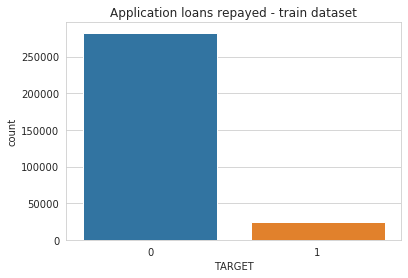

In [22]:
df = data[key]
df = df.withColumn('AGE_BIRTH', col('DAYS_BIRTH')/-365)
df = df.withColumn('YEAR_EMPLOYED', col('DAYS_EMPLOYED')/-365)
count = df.groupby('TARGET').count().toPandas()

#Plot label frequency
plt.title('Application loans repayed - train dataset')
sns.set_color_codes("pastel")
sns.barplot(x = 'TARGET', y="count", data=count)
locs, labels = plt.xticks()

**Comment**

As can be seen, this is an imbalanced class problem. There are more loans that were repaid on time than loands that were not repaid. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

In [23]:
def plot_freq(df, feature, horizontal_layout=True, label_rotation=False):
    temp = df.where(col(feature).isNotNull()).groupby(feature).count().sort(feature,ascending=True)
    temp = temp.toPandas().rename(columns = {'count':'Nbr_contracts'})
    
    # Calculate the percentage of TARGET = 1 per category value
    df_per = df.where(col(feature).isNotNull()).select([feature, 'TARGET']).groupBy(feature).mean()
    df_per = df_per.select([feature, 'avg(TARGET)']).sort(feature,ascending=True).toPandas()
    
    # Plot
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,8))
        plt.subplots_adjust(hspace=0.7)
    
    s = sns.barplot(ax=ax1, x = feature, y="Nbr_contracts",data=temp)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
           
    s = sns.barplot(ax=ax2, x = feature, y='avg(TARGET)',order=df_per[feature],data=df_per)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)

    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

In [24]:
def plot_dist(df, feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(df.select(feature).toPandas().dropna(),color=color, kde=True,bins=100)

## 3.2. Categorical variables

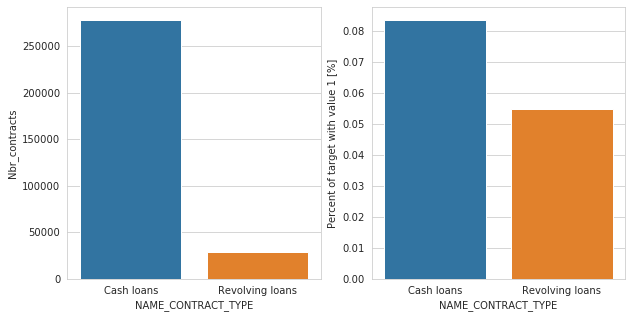

In [25]:
plot_freq(df, 'NAME_CONTRACT_TYPE')

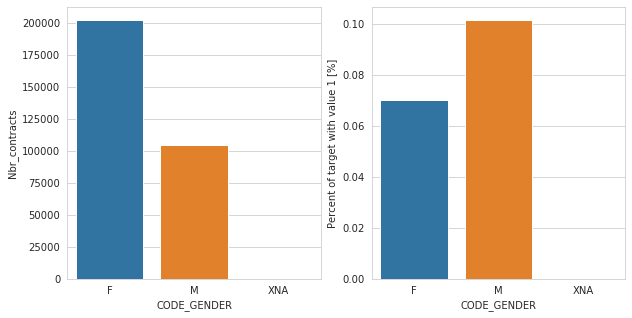

In [26]:
plot_freq(df, 'CODE_GENDER')

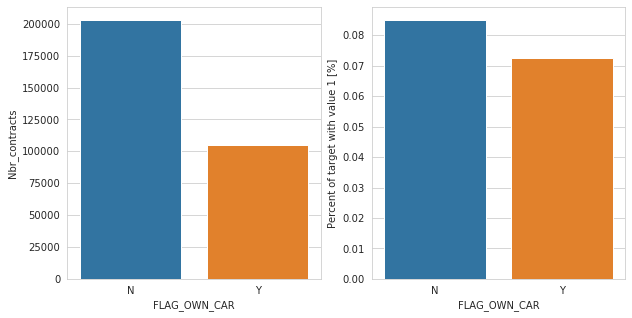

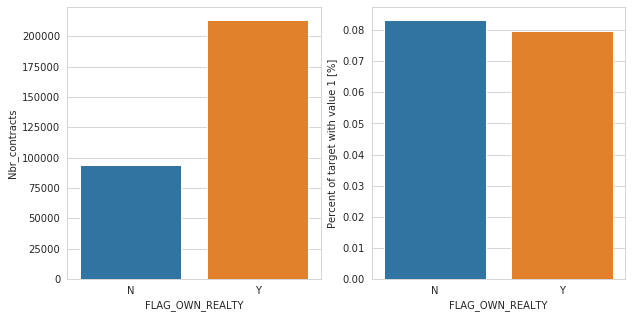

In [27]:
plot_freq(df, 'FLAG_OWN_CAR')
plot_freq(df, 'FLAG_OWN_REALTY')

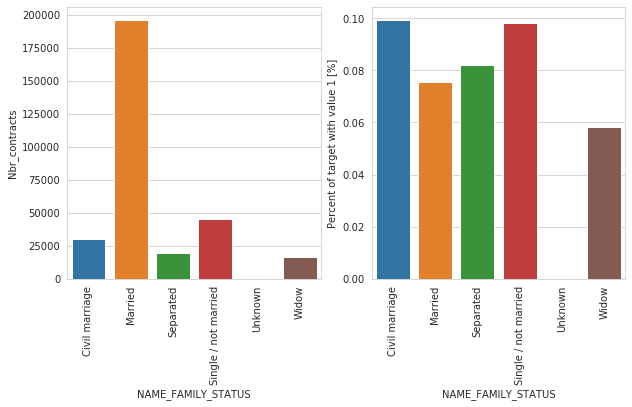

In [28]:
plot_freq(df, 'NAME_FAMILY_STATUS', True, True)

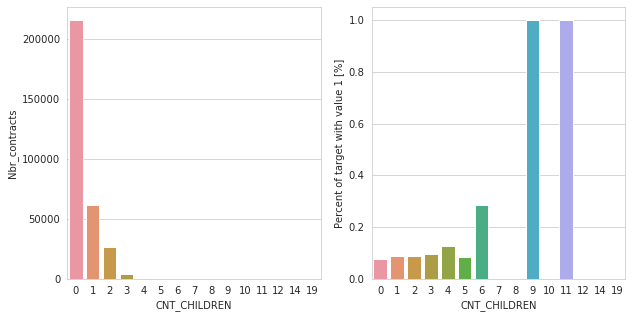

In [29]:
plot_freq(df, 'CNT_CHILDREN')

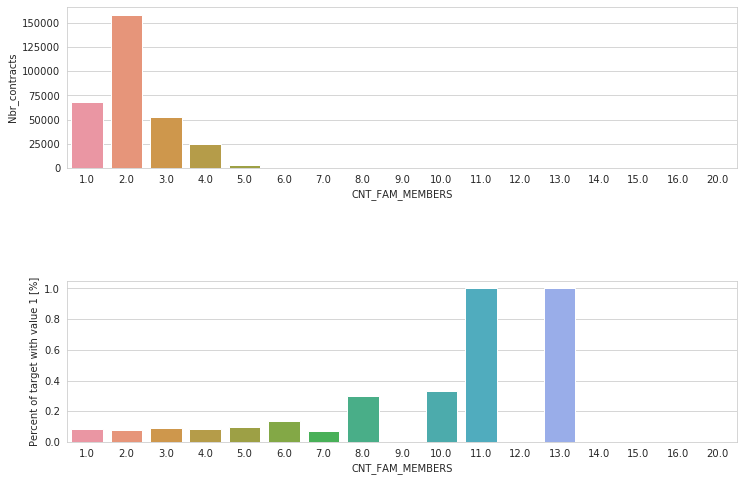

In [30]:
plot_freq(df, 'CNT_FAM_MEMBERS', False, False)

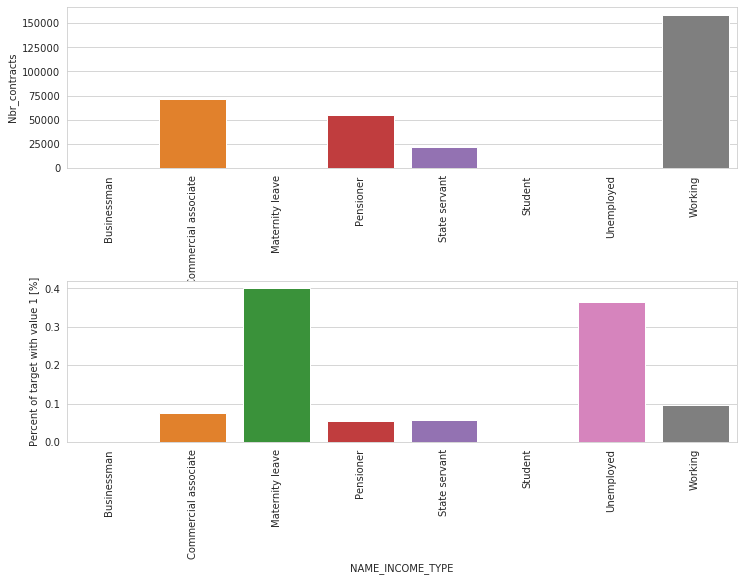

In [31]:
plot_freq(df, 'NAME_INCOME_TYPE', False, True)

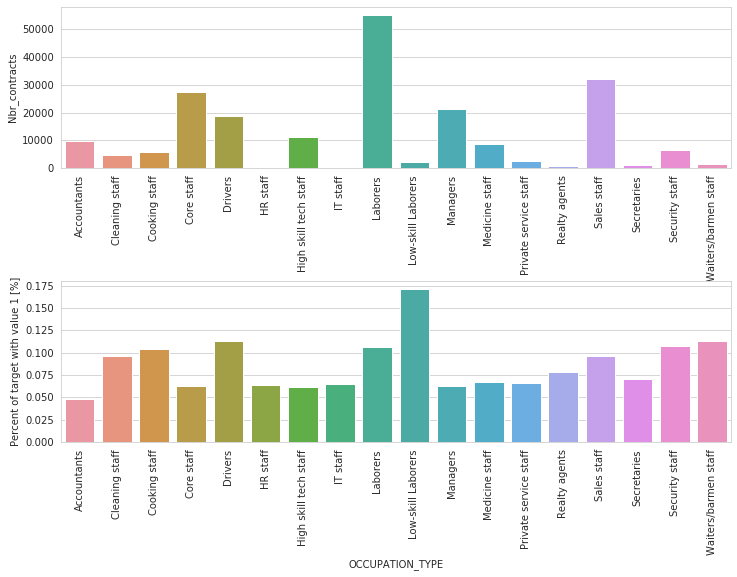

In [32]:
plot_freq(df, 'OCCUPATION_TYPE',False, True)

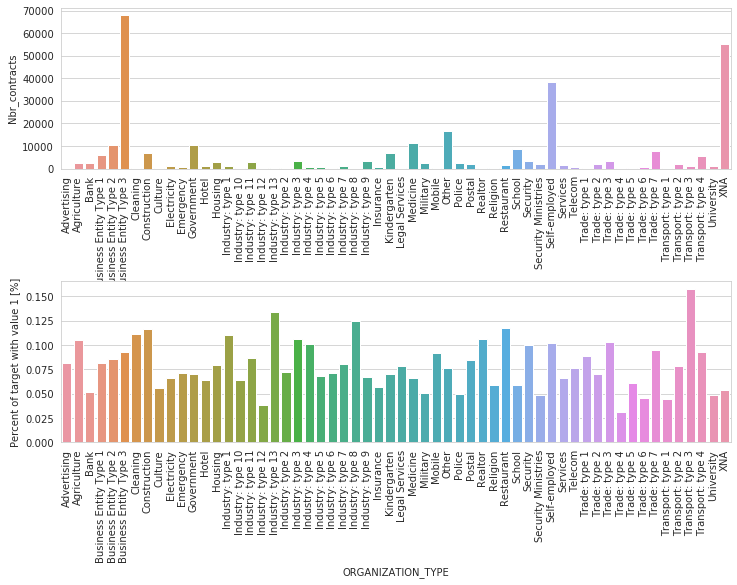

In [33]:
plot_freq(df, 'ORGANIZATION_TYPE',False, True)

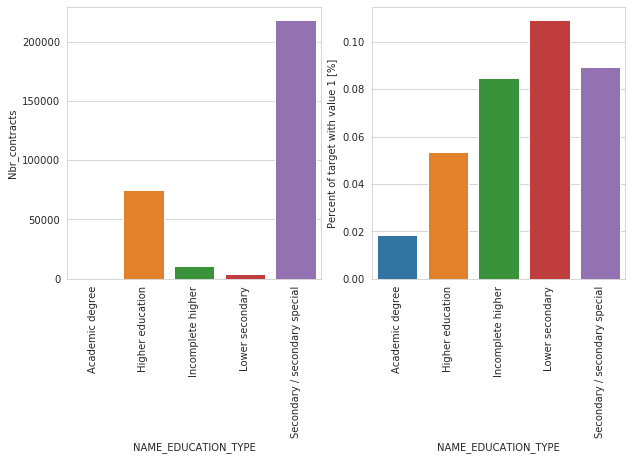

In [34]:
plot_freq(df,'NAME_EDUCATION_TYPE',True, True)

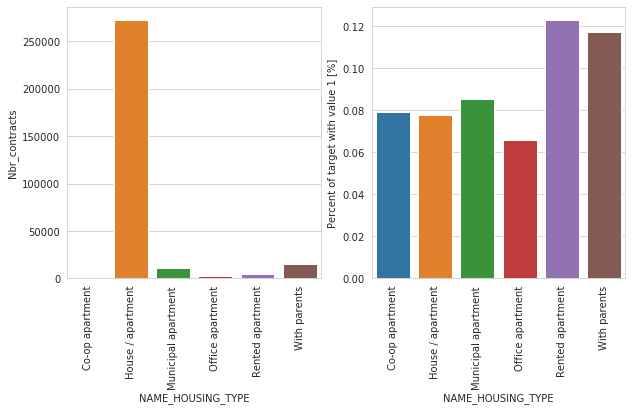

In [35]:
plot_freq(df,'NAME_HOUSING_TYPE',True, True)

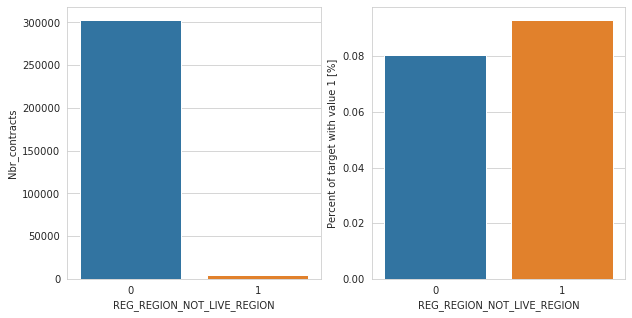

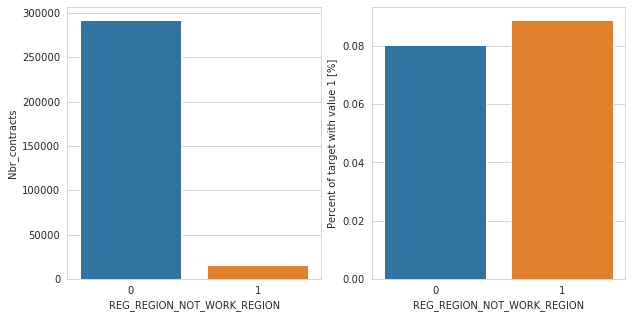

In [36]:
plot_freq(df,'REG_REGION_NOT_LIVE_REGION')
plot_freq(df,'REG_REGION_NOT_WORK_REGION')

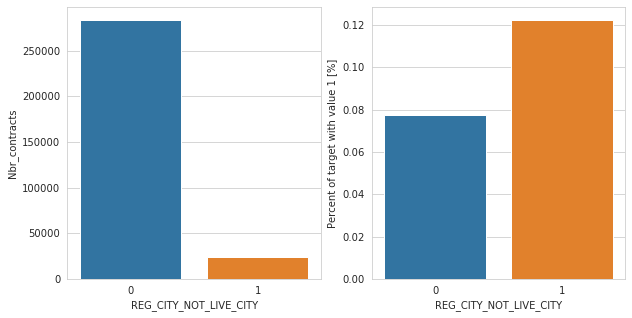

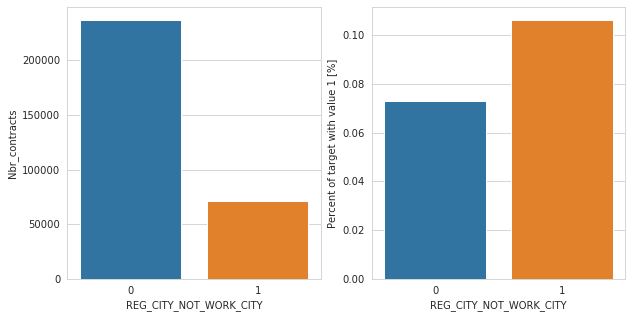

In [37]:
plot_freq(df,'REG_CITY_NOT_LIVE_CITY')
plot_freq(df,'REG_CITY_NOT_WORK_CITY')

## 3.3. Numerical variables

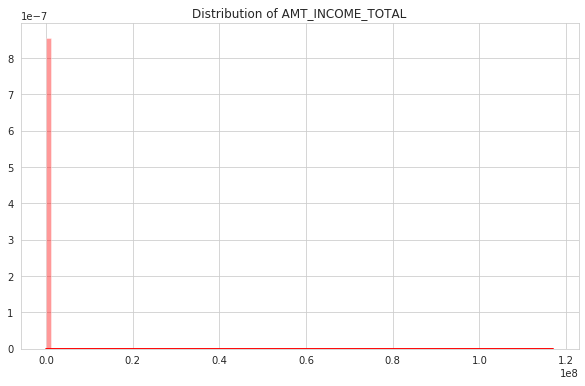

In [38]:
plot_dist(df,'AMT_INCOME_TOTAL', 'red')

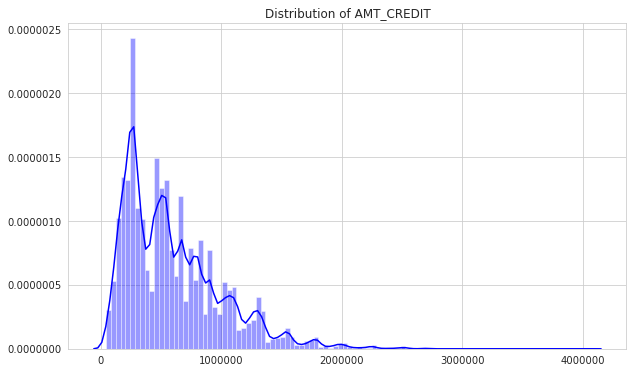

In [39]:
plot_dist(df,'AMT_CREDIT','blue')

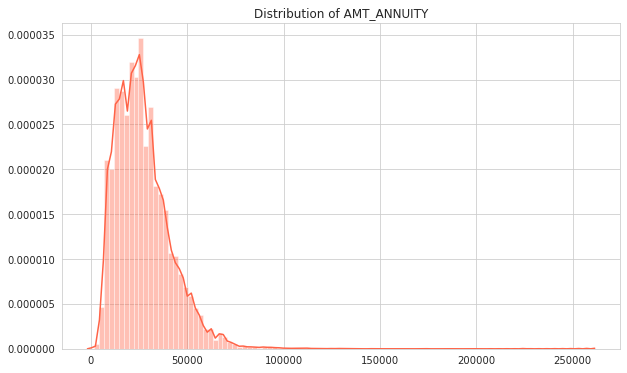

In [40]:
plot_dist(df,'AMT_ANNUITY','tomato')

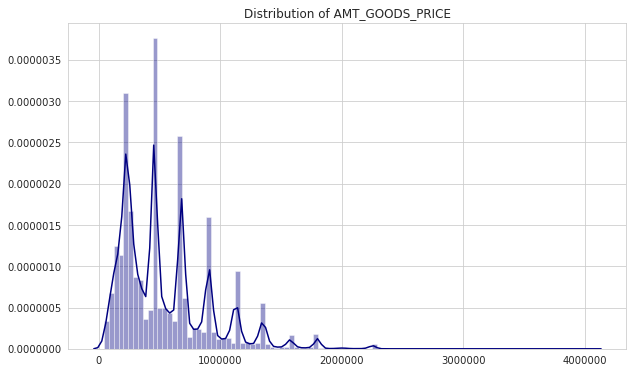

In [41]:
plot_dist(df,'AMT_GOODS_PRICE','navy')

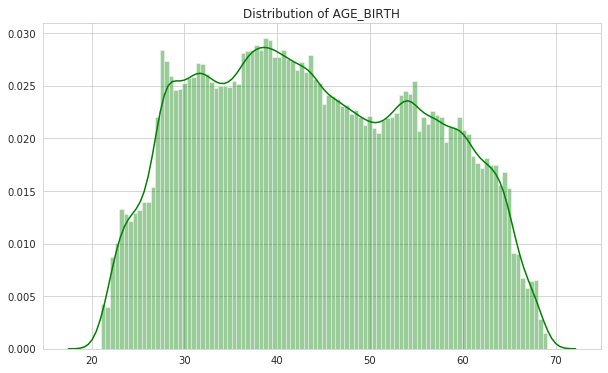

In [42]:
plot_dist(df,'AGE_BIRTH','green')

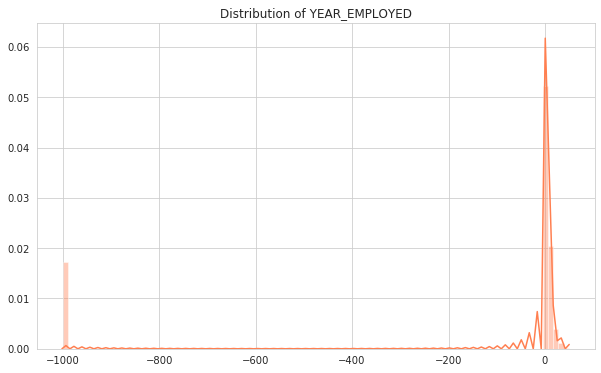

In [43]:
plot_dist(df,'YEAR_EMPLOYED','coral')

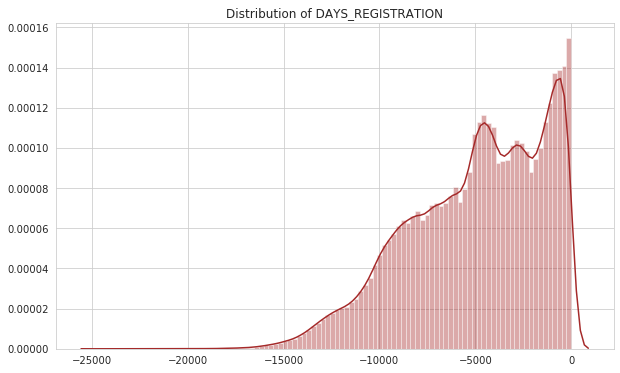

In [44]:
plot_dist(df,'DAYS_REGISTRATION','brown')

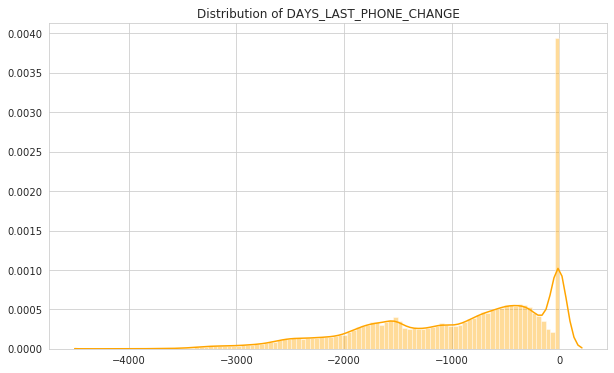

In [45]:
plot_dist(df,'DAYS_LAST_PHONE_CHANGE','orange')

Correlation AMT_ANNUITY and TARGET is -0.0128
Median value for default loan = 25263.0000
Median value for non-default loan = 24876.0000


Correlation AMT_CREDIT and TARGET is -0.0304
Median value for default loan = 497520.0000
Median value for non-default loan = 517788.0000


Correlation AMT_GOODS_PRICE and TARGET is -0.0396
Median value for default loan = 450000.0000
Median value for non-default loan = 450000.0000


Correlation YEAR_EMPLOYED and TARGET is 0.0449
Median value for default loan = 2.8329
Median value for non-default loan = 3.3836


Correlation DAYS_REGISTRATION and TARGET is 0.0420
Median value for default loan = -4056.0000
Median value for non-default loan = -4544.0000


Correlation AGE_BIRTH and TARGET is -0.0782
Median value for default loan = 39.1288
Median value for non-default loan = 43.4986


Correlation EXT_SOURCE_1 and TARGET is -0.0647
Median value for default loan = 0.0000
Median value for non-default loan = 0.0000


Correlation EXT_SOURCE_2 and TARGET is -0.15

<Figure size 432x288 with 0 Axes>

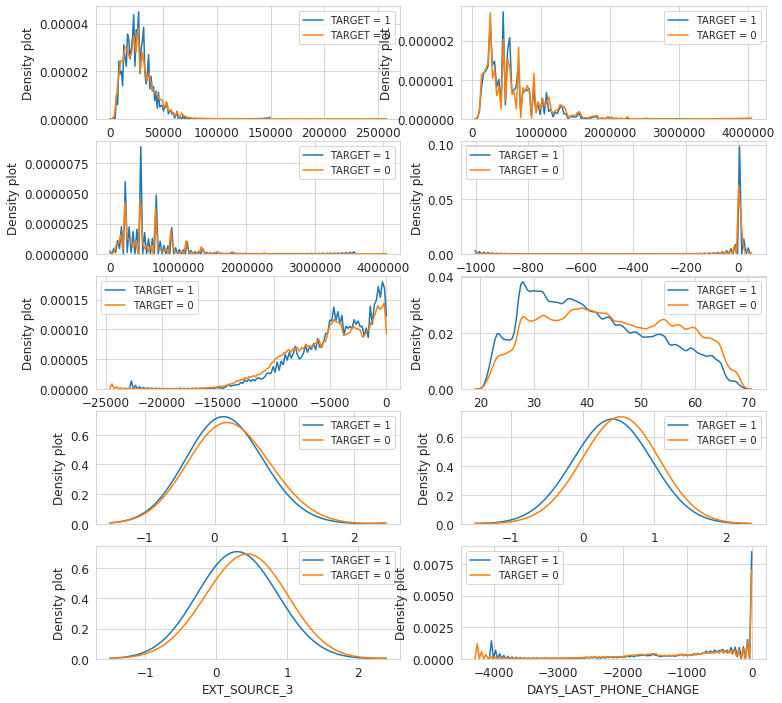

In [46]:
var = [
    'AMT_ANNUITY',
    'AMT_CREDIT',
    'AMT_GOODS_PRICE',
    'YEAR_EMPLOYED', 
    'DAYS_REGISTRATION',
    'AGE_BIRTH',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'DAYS_LAST_PHONE_CHANGE'
]
plot_dist_TARGET(df, var, nrow=5)

# 4. EDA `bureau`

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).

In [47]:
key = 'bureau'
print('Dataframe {} includes {} features (columns) and {} observations.'.format(
    key,
    len(data[key].columns),
    data[key].count()
))
data[key].printSchema()

Dataframe bureau includes 17 features (columns) and 1716428 observations.
root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- SK_ID_BUREAU: integer (nullable = true)
 |-- CREDIT_ACTIVE: string (nullable = true)
 |-- CREDIT_CURRENCY: string (nullable = true)
 |-- DAYS_CREDIT: integer (nullable = true)
 |-- CREDIT_DAY_OVERDUE: integer (nullable = true)
 |-- DAYS_CREDIT_ENDDATE: double (nullable = true)
 |-- DAYS_ENDDATE_FACT: double (nullable = true)
 |-- AMT_CREDIT_MAX_OVERDUE: double (nullable = true)
 |-- CNT_CREDIT_PROLONG: integer (nullable = true)
 |-- AMT_CREDIT_SUM: double (nullable = true)
 |-- AMT_CREDIT_SUM_DEBT: double (nullable = true)
 |-- AMT_CREDIT_SUM_LIMIT: double (nullable = true)
 |-- AMT_CREDIT_SUM_OVERDUE: double (nullable = true)
 |-- CREDIT_TYPE: string (nullable = true)
 |-- DAYS_CREDIT_UPDATE: integer (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)



In [48]:
df_br = data['bureau'].select([F.col(c).alias("BUREAU_"+c) for c in data['bureau'].columns])

bureau_merge = data['application_train'].join(
    df_br,
    data['application_train'].SK_ID_CURR == df_br.BUREAU_SK_ID_CURR,
    how = 'left_outer'
)

# # Fill missing values with O
# bureau_merge = bureau_merge.fillna(
#     0, 
#     subset = [c for c in bureau_merge.columns if c.startswith('BUREAU_')]
# )

# Total number of observations
bureau_merge.count()

1509345

## 4.1. Categorical features

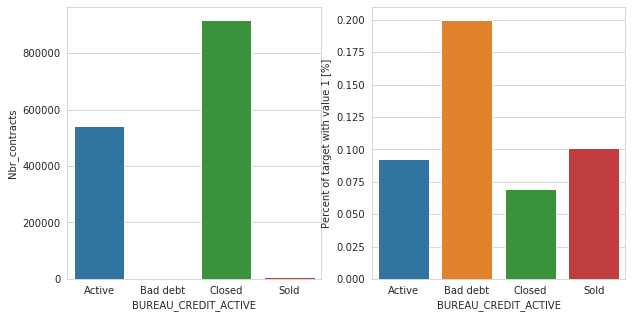

In [49]:
plot_freq(bureau_merge, 'BUREAU_CREDIT_ACTIVE')

Most of the credits registered at the Credit Bureau are in the status `Closed` (~900K). On the second place are the `Active` credits ( a bit under 600K). `Sold` and `Bad debt` are just a few.

In the same time, as percent having `TARGET = 1` from total number per category, clients with credits registered to the Credit Bureau with `Bad debt` have 20% default on the currrent applications.

Clients with credits `Sold`, `Active` and `Closed` have percent of `TARGET == 1` (default credit) equal or less than 10% (10% being the rate overall). The smallest rate of default credit have the clients with credits registered at the Credit Bureau with `Closed` credits.

That means the former registered credit history (as registered at Credit Bureau) is a strong predictor for the default credit, since the percent of applications defaulting with a history of `Bad debt` is twice as large as for `Sold` or `Active` and almost three times larger as for `Closed`.

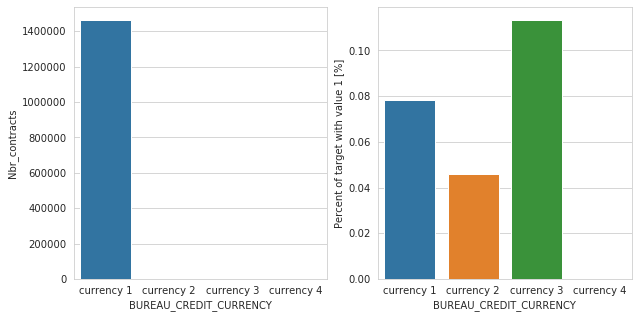

In [50]:
plot_freq(bureau_merge, 'BUREAU_CREDIT_CURRENCY')

Credits are provided mostly in `currency_1`.

Depending on the currency, the percent of clients defaulting is quite different. Highest with `currency_3`, then `currency_1` and `currency_2`, the percent of clients defaulting is 11%, 8% and 5%, respectively. Percent of defaulting applications for clients that have credits registered with `currency_4` is close to 0.

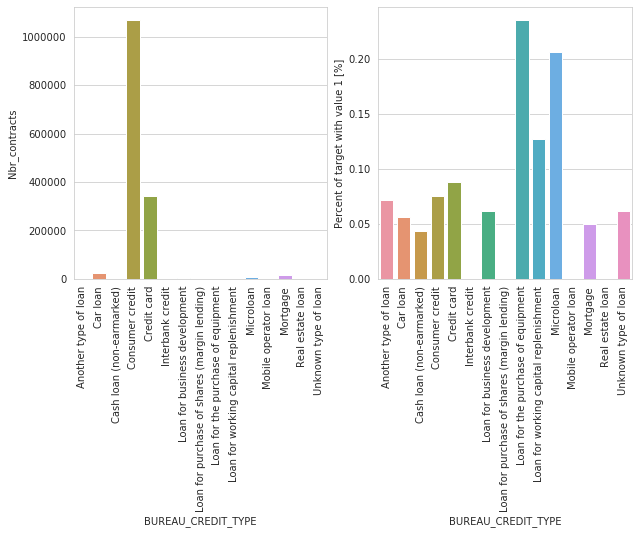

In [51]:
plot_freq(bureau_merge, 'BUREAU_CREDIT_TYPE', True, True)

Majority of historical credits registered at the Credit Bureau are `Consumer credit` and `Credit card`. Smaller number of credits are `Car loan`, `Mortgage` and `Microloan`.

Several features should be taken notes here is that:

- Loan for the purchase of equipment - with over 20% current credits defaults
- Microloan - with over 20% current credits defaults
- Loan for working capital replenishement - with over 12% current credits defaults.

## 4.2. Numerical features

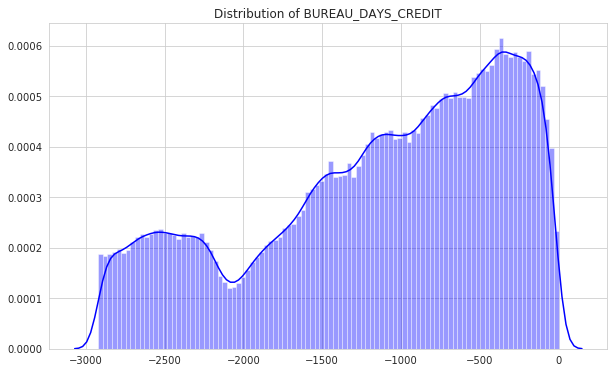

In [52]:
plot_dist(bureau_merge, 'BUREAU_DAYS_CREDIT', 'blue')

The credit duration (in days) is ranging between less than 3000 days (with a local sadle around 2000 days) and with a increasing frequence for shorter number of days - and with a peak around 300 days (or less than one year). Noted that values of 0 comprised the missing data.

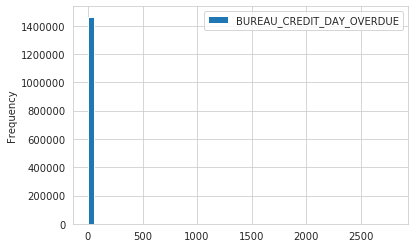

In [53]:
bureau_merge.select('BUREAU_CREDIT_DAY_OVERDUE').toPandas().plot.hist(bins = 50)

Most of the credits have 0 or close to 0 days overdue. The maximum number of credit days overdue is ~3000 days.

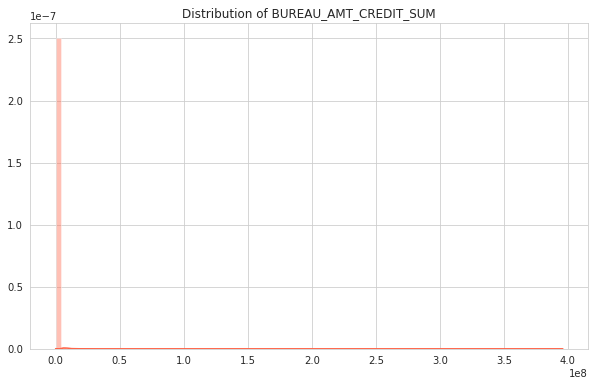

In [54]:
plot_dist(bureau_merge,'BUREAU_AMT_CREDIT_SUM', 'tomato')

The distribution of the `BUREAU_AMT_CREDIT_SUM` shows a concentration of the credits for the lower credit sum range. Let's remove the outliers so that we can see better the distribution around 0.

We can observe that the distribution function shows several peaks and the maximum concentration of the values is around 20,000 but we also see several other peaks at higher values.

Correlation BUREAU_DAYS_CREDIT and TARGET is 0.0621
Median value for default loan = -726.0000
Median value for non-default loan = -970.0000


Correlation BUREAU_CREDIT_DAY_OVERDUE and TARGET is 0.0025
Median value for default loan = 0.0000
Median value for non-default loan = 0.0000


Correlation BUREAU_AMT_CREDIT_SUM and TARGET is -0.0112
Median value for default loan = 112500.0000
Median value for non-default loan = 117000.0000


Correlation BUREAU_AMT_CREDIT_SUM_LIMIT and TARGET is -0.0051
Median value for default loan = 0.0000
Median value for non-default loan = 0.0000




<Figure size 432x288 with 0 Axes>

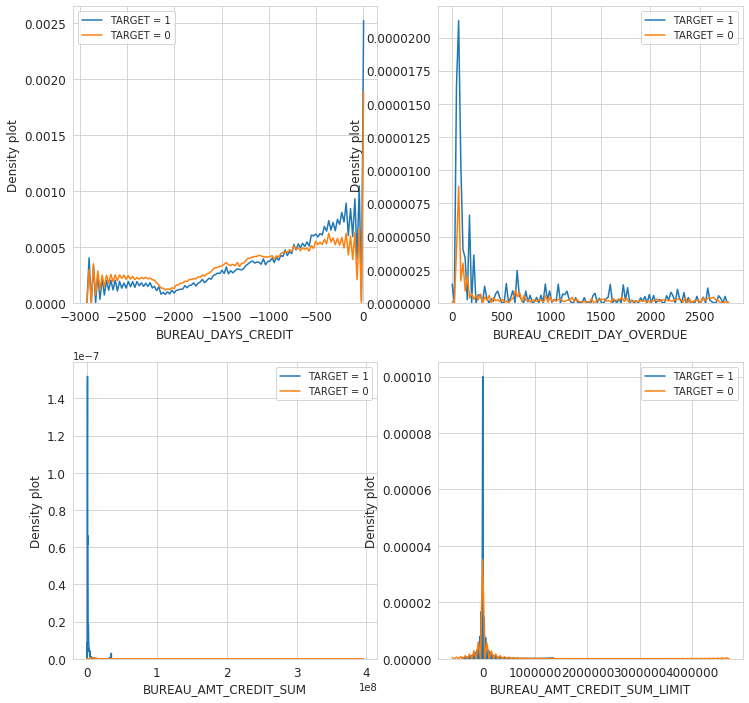

In [55]:
var = [
    'BUREAU_DAYS_CREDIT',
    'BUREAU_CREDIT_DAY_OVERDUE',
    'BUREAU_AMT_CREDIT_SUM', 
    'BUREAU_AMT_CREDIT_SUM_LIMIT'
]
plot_dist_TARGET(bureau_merge, var, nrow=2)

# 5. EDA `previous_application`

In [56]:
key = 'previous_application'
print('Dataframe {} includes {} features (columns) and {} observations.'.format(
    key,
    len(data[key].columns),
    data[key].count()
))
data[key].printSchema()

Dataframe previous_application includes 37 features (columns) and 1670214 observations.
root
 |-- SK_ID_PREV: integer (nullable = true)
 |-- SK_ID_CURR: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_APPLICATION: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_DOWN_PAYMENT: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- WEEKDAY_APPR_PROCESS_START: string (nullable = true)
 |-- HOUR_APPR_PROCESS_START: integer (nullable = true)
 |-- FLAG_LAST_APPL_PER_CONTRACT: string (nullable = true)
 |-- NFLAG_LAST_APPL_IN_DAY: integer (nullable = true)
 |-- RATE_DOWN_PAYMENT: double (nullable = true)
 |-- RATE_INTEREST_PRIMARY: double (nullable = true)
 |-- RATE_INTEREST_PRIVILEGED: double (nullable = true)
 |-- NAME_CASH_LOAN_PURPOSE: string (nullable = true)
 |-- NAME_CONTRACT_STATUS: string (nullable = true)
 |-- DAYS_DECISION: integer (nullable = true)
 |-- N

In [57]:
df_pa = data[key].select([F.col(c).alias("PREV_"+c) for c in data[key].columns])

pa_merge = data['application_train'].join(
    df_pa,
    data['application_train'].SK_ID_CURR == df_pa.PREV_SK_ID_CURR,
    how = 'left_outer'
)

# Fill missing values with O
# pa_merge = pa_merge.fillna(
#     0, 
#     subset = [c for c in pa_merge.columns if c.startswith('PREV_')]
# )

# Total number of observations
pa_merge.count()

1430155

## 5.1. Categorical variables

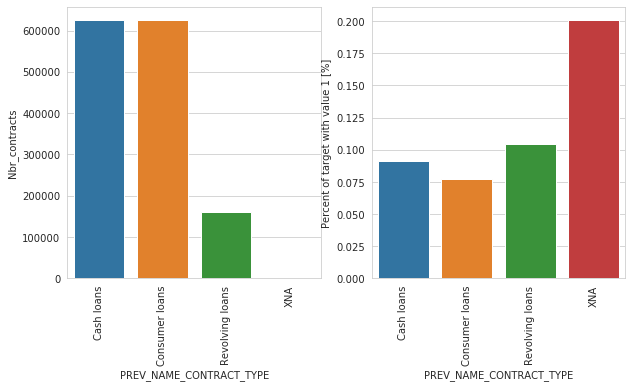

In [58]:
plot_freq(pa_merge, 'PREV_NAME_CONTRACT_TYPE', True, True)

There are three types of contract in the previous application data: `Cash loans`, `Consumer loans`, `Revolving loans`. `Cash loans` and `Consumer loans` are almost the same number (~600K) whilst `Revolving loans` are ~150K.

The percent of defauls loans for clients with previous applications is different for the type of previous applications contracts, decreasing from ~10% for `Revolving loans`, then ~ 9.5% for `Cash loans` and ~8% for `Consumer loans`.

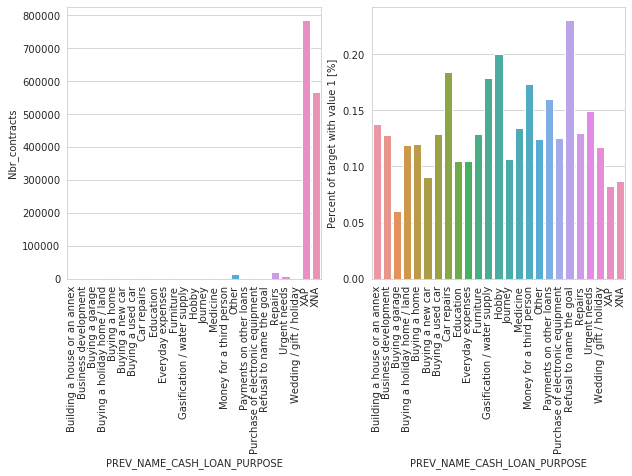

In [59]:
plot_freq(pa_merge, 'PREV_NAME_CASH_LOAN_PURPOSE', True, True)

Besides not identifed/not available categories, `Repairs`, `Other`, `Urgent needs`, `Buying a used car`, `Building a house` or an annex accounts for the largest number of contracts.

In terms of percent of defaults for current applications in the sample, clients with history of previous applications have largest percents of defaults when in their history are previous applications for cash loans for `Refusal to name the goal` \~23% (which makes a lot of sense), `Hobby` (20%), `Car repairs` (\~18%).

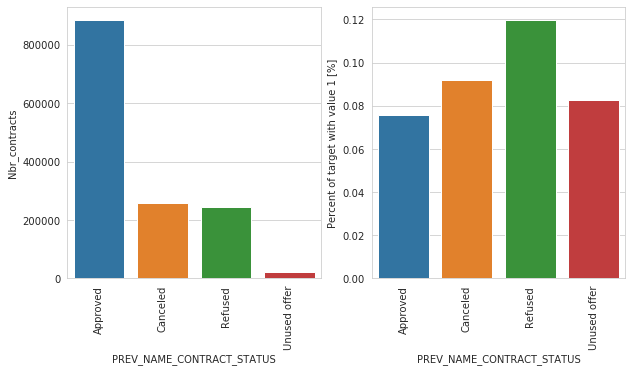

In [60]:
plot_freq(pa_merge, 'PREV_NAME_CONTRACT_STATUS', True, True)

Most previous applications contract statuses are `Approved` (\~850K), `Canceled` and `Refused` (\~240K). There are only \~20K in status `Unused offer`.

In terms of percent of defaults for current applications in the sample, clients with history of previous applications have largest percents of defaults when in their history contract statuses are `Refused` (12%), followed by `Canceled` (9%), `Unused offer` (~8%) and `Approved` (lowest percent of defaults in current applictions, with less than 8%).

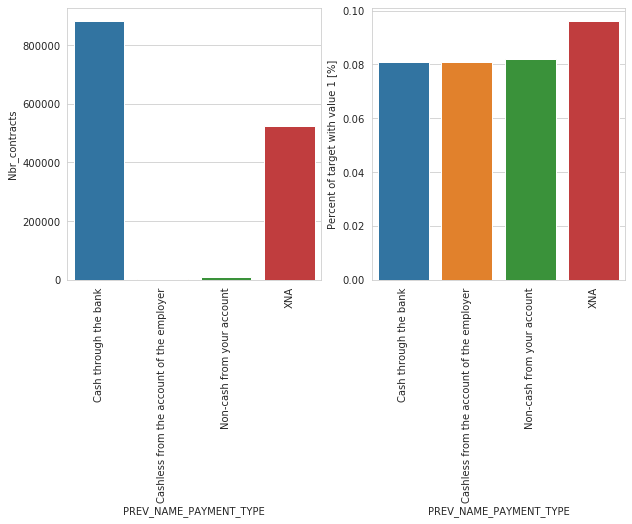

In [61]:
plot_freq(pa_merge, 'PREV_NAME_PAYMENT_TYPE', True, True)

Most of the previous applications were paid with `Cash through the bank` (\~850K). Payments using `Non-cash from your account` or `Cashless from the account of the employer` are much rare. These three types of payments in previous applications results in almost the same percent of defaults for current clients (\~8% each).

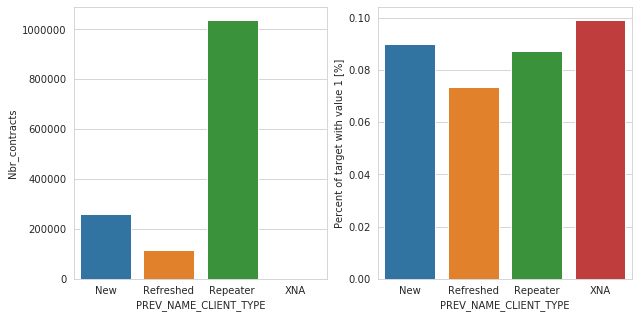

In [62]:
plot_freq(pa_merge, 'PREV_NAME_CLIENT_TYPE')

Most of the previous applications have client type `Repeater` (\~1M), just over 200K are `New` and \~100K are `Refreshed`.

In terms of default percent for current applications of clients with history of previous applications, current clients with previous applications have values of percent of defaults ranging from from 8.5%, 8.25% and 7% corresponding to client types in the past `New`, `Repeater` and `Refreshed`, respectivelly.

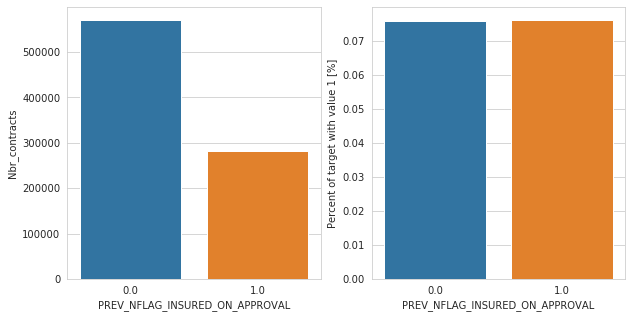

In [63]:
plot_freq(pa_merge, 'PREV_NFLAG_INSURED_ON_APPROVAL')

## 5.2. Numerical variables

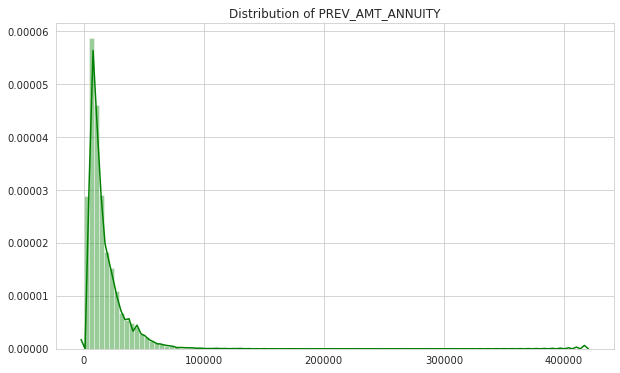

In [64]:
plot_dist(pa_merge, 'PREV_AMT_ANNUITY', 'green')

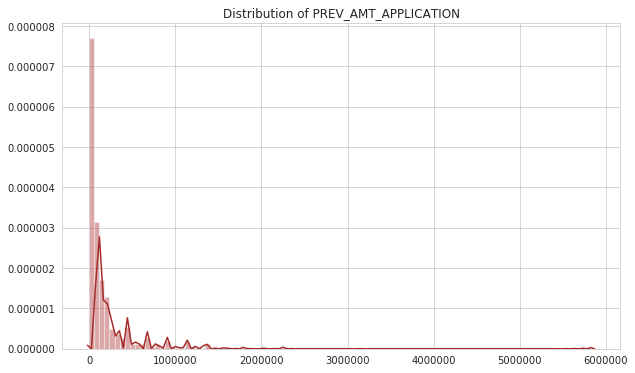

In [65]:
plot_dist(pa_merge, 'PREV_AMT_APPLICATION', 'brown')

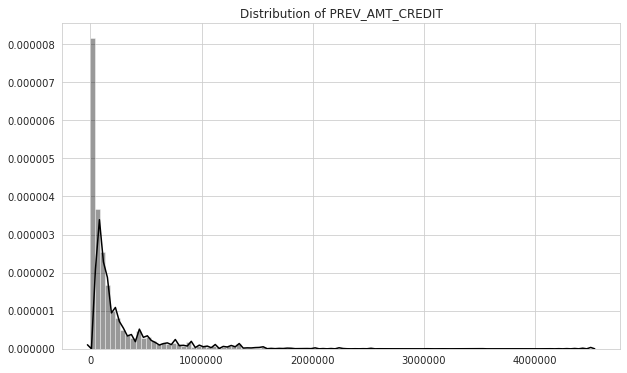

In [66]:
plot_dist(pa_merge, 'PREV_AMT_CREDIT', 'black')

Correlation PREV_AMT_ANNUITY and TARGET is -0.0197
Median value for default loan = 7307.8200
Median value for non-default loan = 8160.7950


Correlation PREV_AMT_APPLICATION and TARGET is -0.0049
Median value for default loan = 65026.8000
Median value for non-default loan = 69525.0000


Correlation PREV_AMT_CREDIT and TARGET is -0.0017
Median value for default loan = 73314.0000
Median value for non-default loan = 78826.5000


Correlation PREV_DAYS_FIRST_DUE and TARGET is -0.0101
Median value for default loan = -56.0000
Median value for non-default loan = -288.0000


Correlation PREV_DAYS_LAST_DUE and TARGET is -0.0017
Median value for default loan = 0.0000
Median value for non-default loan = 0.0000


Correlation PREV_DAYS_TERMINATION and TARGET is -0.0028
Median value for default loan = 0.0000
Median value for non-default loan = 0.0000




<Figure size 432x288 with 0 Axes>

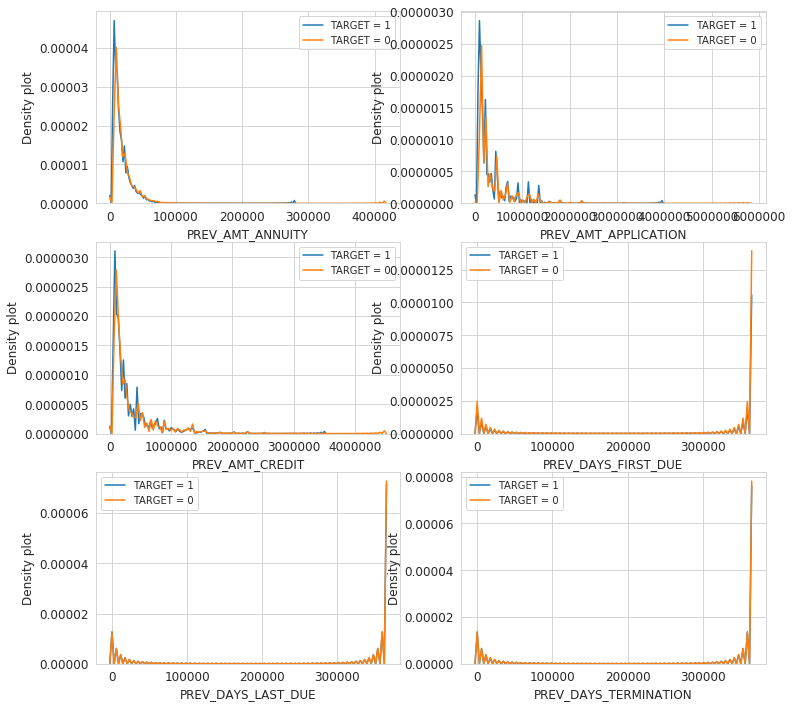

In [67]:
var = [
    'PREV_AMT_ANNUITY',
    'PREV_AMT_APPLICATION',
    'PREV_AMT_CREDIT',
    'PREV_DAYS_FIRST_DUE',
    'PREV_DAYS_LAST_DUE',
    'PREV_DAYS_TERMINATION'
]
plot_dist_TARGET(pa_merge, var, nrow=3)

# 6. Merging final dataset

In [68]:
filename = [
    'application_train',
    'bureau',
    'previous_application'
]

cols_application_train = [
    'SK_ID_CURR',
     'TARGET',
     'NAME_CONTRACT_TYPE',
     'CODE_GENDER',
     'FLAG_OWN_CAR',
     'FLAG_OWN_REALTY',
     'CNT_CHILDREN',
     'AMT_INCOME_TOTAL',
     'AMT_CREDIT',
     'AMT_ANNUITY',
     'AMT_GOODS_PRICE',
     'NAME_INCOME_TYPE',
     'NAME_EDUCATION_TYPE',
     'NAME_FAMILY_STATUS',
     'NAME_HOUSING_TYPE',
     'DAYS_BIRTH',
     'DAYS_EMPLOYED',
     'DAYS_REGISTRATION',
     'OCCUPATION_TYPE',
     'CNT_FAM_MEMBERS',
     'REG_REGION_NOT_LIVE_REGION',
     'REG_REGION_NOT_WORK_REGION',
     'REG_CITY_NOT_LIVE_CITY',
     'REG_CITY_NOT_WORK_CITY',
     'ORGANIZATION_TYPE',
     'EXT_SOURCE_1',
     'EXT_SOURCE_2',
     'EXT_SOURCE_3',
     'DAYS_LAST_PHONE_CHANGE'
]

cols_bureau = [
    'SK_ID_CURR',
    'SK_ID_BUREAU',
    'CREDIT_ACTIVE',
    'DAYS_CREDIT',
    'DAYS_CREDIT_ENDDATE', 
    'AMT_CREDIT_SUM', 
    'AMT_CREDIT_SUM_OVERDUE', 
    'CREDIT_TYPE'
]

cols_pa = [
    'SK_ID_PREV',
    'SK_ID_CURR',
    'NAME_CONTRACT_TYPE',
    'AMT_ANNUITY', 
    'AMT_APPLICATION', 
    'AMT_CREDIT', 
    'AMT_GOODS_PRICE', 
    'NAME_CONTRACT_STATUS', 
    'NAME_CLIENT_TYPE',
    'DAYS_LAST_DUE',
    'DAYS_TERMINATION',
    'NFLAG_INSURED_ON_APPROVAL'
]

cols_keep = [cols_application_train, cols_bureau, cols_pa]

In [69]:
data_keep = {}

# Store all datafiles in a dictionary
for idx, file in enumerate(filename):
    if file in data_keep.keys():
        print(file + ' already exists in dictionary')
    else:
        filepath = '../home-credit-default-risk/' + file + '.csv'
        dff = spark.read.csv(
            filepath, 
            header = True,
            sep = ',',
            inferSchema = True
        ).select(cols_keep[idx])
        data_keep[file] = dff

In [70]:
df_bureau = data_keep['bureau'].\
select([F.col(c).alias("BUREAU_"+c) for c in data_keep['bureau'].columns])

df_previous = data_keep['previous_application'].\
select([F.col(c).alias("PREV_"+c) for c in data_keep['previous_application'].columns])

In [71]:
dff = data_keep['application_train'].join(
    df_bureau,
    data_keep['application_train'].SK_ID_CURR == df_bureau.BUREAU_SK_ID_CURR,
    how = 'left_outer'
)

df_final = dff.join(
    df_previous,
    dff.SK_ID_CURR == df_previous.PREV_SK_ID_CURR,
    how = 'left_outer'
)

df_final.count()

8091522

In [72]:
# Check number of distinct current application ID
df_final.select(F.countDistinct("SK_ID_CURR")).collect()[0][0]

307511

In [73]:
dta = spark.createDataFrame(df_final.rdd)
dta.write.parquet('train.parquet')

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 50958)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.7/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.7/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.7/socketserver.py", line 720, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 269, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/usr/local/spark/python/pyspark/accumulators.py", line 245, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/local/spark/python/pysp